In [1]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import numpy as np


In [2]:
tmp_dir = '/home/combet/tmp_new/' # change it to where you want to write the files
slot = '11'   
path = '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red'
mean_bias_file = slot + '_mean_bias_image_RTM-006_LSSTTD-1101.fits'
bias_frames = glob.glob(os.path.join(path, slot + '_bias*'))
bias_frames


['/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_bias_0003_20180420195748.fits.fz',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_bias_0000_20180420195731.fits.fz',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_bias_0002_20180420195742.fits.fz',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_bias_0001_20180420195737.fits.fz',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_bias_0004_20180420195754.fits.fz']

In [3]:
imutils.fits_mean_file(bias_frames,os.path.join(tmp_dir,mean_bias_file))

### Read in one bias frame as reference and compare to imutils.fits_mean_file
- Just printing min and max values
- Mean bias frame built from fits_mean_file has values orders of magnitude higher than any of the individual bias frames
- It seems the fitsWriteto function is responsible, see below

In [4]:
ref = sensorTest.MaskedCCD(bias_frames[0])
mean_bias = sensorTest.MaskedCCD(os.path.join(tmp_dir,mean_bias_file))
d_ref = ref[1].getImage().getArray()
d_mean = mean_bias[1].getImage().getArray()

print("min ref = %i\nmax ref = %i"%(np.min(d_ref), np.max(d_ref)))
print("\nmin mean = %i\nmax mean = %i"%(np.min(d_mean), np.max(d_mean)))

min ref = 25564
max ref = 49365

min mean = 25569
max mean = 44186


### Modification to fits_mean_file to return the array, as well as saving it to .fits file

In [5]:
from __future__ import print_function
from __future__ import absolute_import
from builtins import zip
from builtins import range
from builtins import object
import astropy.io.fits as fits
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.eotest.fitsTools import fitsWriteto

def allAmps(fits_file=None):
    all_amps = list(range(1, 17))
    if fits_file is None:
        return all_amps
    try:
        f = fits.open(fits_file)
        f.close()  # close first, in case exception is thrown and file is left open
        namps = f[0].header['NAMPS']
        return list(range(1, namps+1))
    except KeyError:
        return all_amps

def my_fits_mean_file(files, outfile, overwrite=True):
    output = fits.HDUList()
    output.append(fits.PrimaryHDU())
    all_amps = allAmps()
    for amp in all_amps:
        images = [afwImage.ImageF(item, amp) for item in files]
        mean_image = afwMath.statisticsStack(images, afwMath.MEAN)
        output.append(fits.CompImageHDU(data=mean_image.getArray(),
                                        compression_type='RICE_1'))
    with fits.open(files[0]) as template:
        output[0].header.update(template[0].header)
        for amp in all_amps:
            output[amp].header.update(template[amp].header)
            try:
                del output[amp].header['BSCALE']
                del output[amp].header['BZERO']
            except KeyError:
                pass
        for i in (-3, -2, -1):
            output.append(template[i])
        fitsWriteto(output, outfile, overwrite=overwrite)    
    return output

In [6]:
mean_bias_file_new = slot + '_mean_bias_image_RTM-006_LSSTTD-1101_new.fits'
m = my_fits_mean_file(bias_frames,os.path.join(tmp_dir,mean_bias_file_new))

In [7]:
mean_bias = sensorTest.MaskedCCD(os.path.join(tmp_dir,mean_bias_file_new))
d_mean = mean_bias[1].getImage().getArray()
print("From ref:\nmin = %i\nmax = %i"%(np.min(d_ref), np.max(d_ref)))
print("\nFrom mean output (what is written to the fits file, looks OK):\nmin = %i\nmax = %i"%(np.min(m[1].data), np.max(m[1].data)))
print("\nFrom mean file (what is read from the fits file, not OK):\nmin = %i\nmax = %i"%(np.min(d_mean), np.max(d_mean)))


From ref:
min = 25564
max = 49365

From mean output (what is written to the fits file, looks OK):
min = 25568
max = 44186

From mean file (what is read from the fits file, not OK):
min = 1187496320
max = 1194105344


### Unrelated, but show that plot_flat needs a small fix in python 3

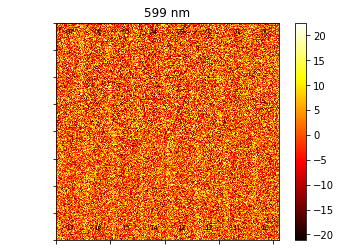

In [5]:
%matplotlib inline
sensorTest.plot_flat(bias_frames[0])

In [11]:
from astropy.io import fits
mean_bias_file_new = slot + '_mean_bias_image_RTM-006_LSSTTD-1101_new.fits'
d = fits.open(os.path.join(tmp_dir,mean_bias_file_new))

In [12]:
d[1].header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  576 / width of table in bytes                        
NAXIS2  =                 2048 / number of rows in table                        
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'Segment10'                                                           
HEADVER =                    1                                                  
CHANNEL =                    1                                                  
EXTNAME = 'Segment10'                                                           
CCDSUM  = '1 1     '                                                            
AVERAGE =     27502.81999683